# File and libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

filepath=r'dataset/df_msg_mv_input.csv'

file_tag = "df_msg_outlier_input"

# DSLabs functions

In [2]:
%run "scripts/dslabs_functions.py"

dslabs lodaded


# Data functions

In [3]:
%run "scripts/data_functions.py"

dslabs lodaded
data_functions lodaded


# Load

In [4]:
# test_data=True
test_data=False
if test_data==True:

    data=pd.read_csv(filepath)

    # 1% sample
    data=data.sample(frac=0.01, replace=False)
    
else:
    data=pd.read_csv(filepath)
    # 50% sample
    # data=data.sample(frac=0.5, replace=False)

target='is_clicked'

# ensure sorting by day_of_year for correct splitting 
# "When in the presence of temporal data, data partition shall use older data to train and newer to test, in order to not use future data to classify past data. In any other case, partition shall be random."
data.sort_values(by='day_of_year', inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 461961 entries, 0 to 461960
Data columns (total 28 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   platform                      461961 non-null  float64
 1   email_provider                461961 non-null  float64
 2   is_clicked                    461961 non-null  float64
 3   campaign_type                 461961 non-null  float64
 4   channel_cmp                   461961 non-null  float64
 5   topic                         461961 non-null  float64
 6   total_count                   461961 non-null  float64
 7   subject_length                461961 non-null  float64
 8   subject_with_personalization  461961 non-null  float64
 9   subject_with_deadline         461961 non-null  float64
 10  subject_with_emoji            461961 non-null  float64
 11  subject_with_bonuses          461961 non-null  float64
 12  subject_with_discount         461961 non-null  fl

In [5]:
data.shape[0]

461961

# Outlier Analysis

- engagement_time_msec is the only numeric column that has outliers that need to be treated
- this is most likely due to idle time by the user when navigating in the page and then clicking on something after some minutes.

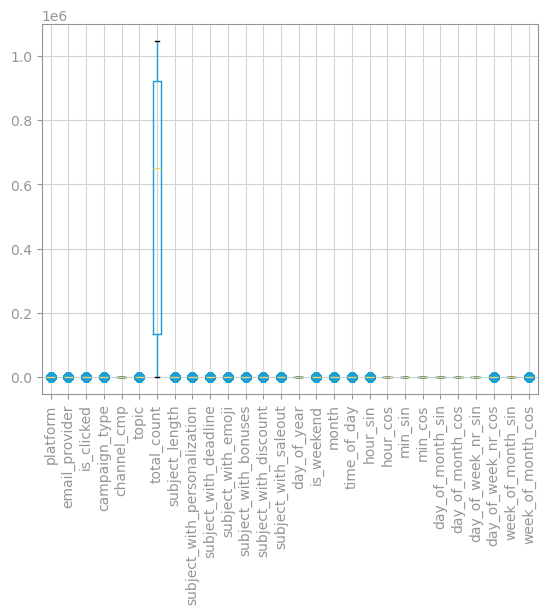

In [9]:
from matplotlib.pyplot import savefig, show


data.boxplot(rot=90)
# savefig(f"{file_tag}_global_boxplot.png")
show()


# Out 1 - Outlier Truncation

## Out 1 strategy aplication

In [7]:
# List of variables you want to apply the outlier strategy to
variables = ['hour']

def apply_strategy_1(df, variables):
    df_copy = df.copy()
    
    for var in variables:
        summary5 = df[[var]].describe(include="all")

        # Determine outlier thresholds for the current variable
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])

        # Apply the truncation strategy to the current variable
        df_copy[var] = df_copy[var].apply(
            lambda x: top if x > top else bottom if x < bottom else x
        )

        print(f"Data after truncating outliers for {var}: {df_copy.shape}")

    return df_copy

data_1 = apply_strategy_1(data, variables)

data_1[variables].describe()

KeyError: "None of [Index(['hour'], dtype='object')] are in the [columns]"

## Out 1 Target Prep

In [ ]:
from numpy import array, ndarray


y_1, X_1, labels, values = define_target_and_prepare_data(data_1, target)


Labels=[0.0, 1.0]


## Out 1 train/test split 

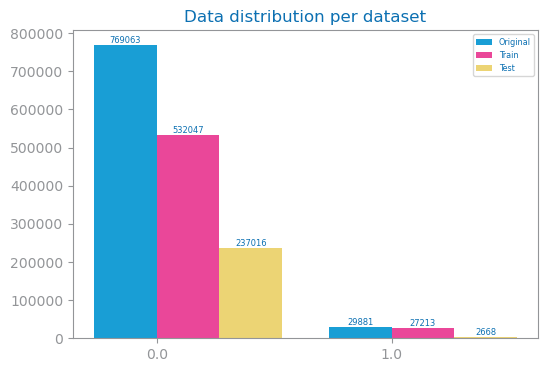

In [ ]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart


# Call the function to split the data
train_1, test_1 = split_data_save_csv(pd.DataFrame(X_1, columns=data_1.columns), y_1, data_columns=data_1.columns, target_column=target)

# Distribution check
values["Train"] = [
    len(train_1[train_1[target] == 0]),
    len(train_1[train_1[target] == 1]),
]
values["Test"] = [
    len(test_1[test_1[target] == 0]),
    len(test_1[test_1[target] == 1]),
]

# Visualize the distribution
figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")
show()

## Out 1 evaluate

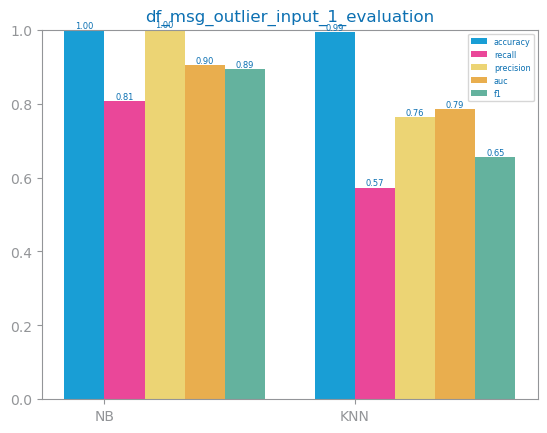

In [ ]:
# evaluate_approach is in data_functions originally from DSLABS/ Data Prep / Methodology
# removed Multinomial from run_NB function because dataset has negative values

figure()
eval_1: dict[str, list] = evaluate_approach(train_1, test_1, target='is_clicked', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_1, title=f"{file_tag}_1_evaluation", percentage=True
)
savefig(f"images/{file_tag}_1_evaluation.png")
show()

# Out 2 - drop outlier strategy


## Out 2 strategy aplication

In [ ]:
from pandas import DataFrame, Series

# List of variables you want to apply the outlier strategy to
variables = ['days_diff_opened_first_time_at_sent_at', 'days_diff_clicked_first_time_at_sent_at', 
             'days_diff_unsubscribed_at_sent_at']

def apply_strategy_2(df, variables):
    df_copy = df.copy()
    
    for var in variables:
        # Calculate the summary statistics for the current variable
        summary5 = df[[var]].describe(include="all")

        # Determine outlier thresholds for the current variable
        top, bottom = determine_outlier_thresholds_for_var(summary5[var])

        # Identify outliers for the current variable
        outliers: DataFrame = df_copy[(df_copy[var] > top) | (df_copy[var] < bottom)]

        # Drop the outliers from the DataFrame
        df_copy.drop(outliers.index, axis=0, inplace=True)

        print(f"Data after removing outliers for {var}: {df_copy.shape}")

    return df_copy

data_2 = apply_strategy_2(data, variables)

data_2[variables].describe()


Data after removing outliers for days_diff_opened_first_time_at_sent_at: (793698, 42)
Data after removing outliers for days_diff_clicked_first_time_at_sent_at: (792750, 42)
Data after removing outliers for days_diff_unsubscribed_at_sent_at: (792359, 42)


,days_diff_opened_first_time_at_sent_at,days_diff_clicked_first_time_at_sent_at,days_diff_unsubscribed_at_sent_at
count,792359.000000,792359.000000,792359.000000
mean,0.967942,1.141444,0.348958
std,0.412757,0.132602,0.068733
min,0.000000,0.000000,-1.000000
25%,1.090705,1.155946,0.362203
50%,1.090705,1.155946,0.362203
75%,1.090705,1.155946,0.362203
max,5.000000,2.000000,1.000000


## Out 2 target prep

In [ ]:
y_2, X_2, labels, class_counts = define_target_and_prepare_data(data_2, target=target)


Labels=[0.0, 1.0]


## Out 2 train/test split 

<Axes: title={'center': 'Data distribution per dataset'}>

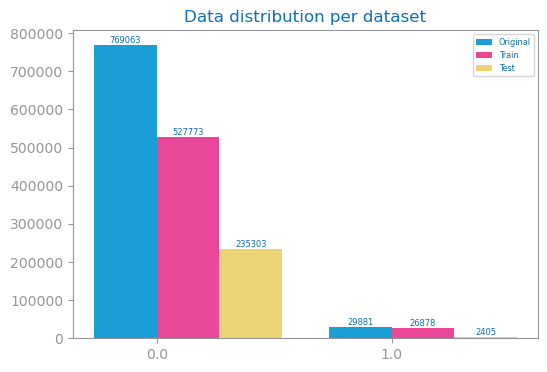

In [ ]:
from pandas import concat
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
from dslabs_functions import plot_multibar_chart

# train/test split from DSLABS Classification/Evaluation Chapter
# created split_data_save_csv on data_functions

# Call the function to split the data
train_2, test_2 = split_data_save_csv(pd.DataFrame(X_2, columns=data_2.columns), y_2, data_columns=data_2.columns, target_column=target)


values["Train"] = [
    len(train_2[train_2[target] == 0]),
    len(train_2[train_2[target] == 1]),
]
values["Test"] = [
    len(test_2[test_2[target] == 0]),
    len(test_2[test_2[target] == 1]),
]

figure(figsize=(6, 4))
plot_multibar_chart(labels, values, title="Data distribution per dataset")

## Out 2 evaluate

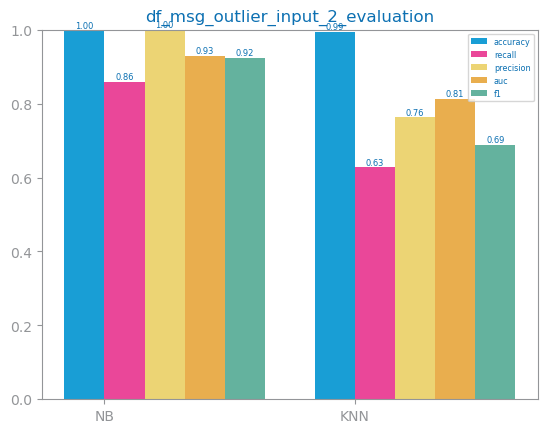

In [ ]:

figure()
eval_2: dict[str, list] = evaluate_approach(train_2, test_2, target='is_clicked', metric="recall")
plot_multibar_chart(
    ["NB", "KNN"], eval_2, title=f"{file_tag}_2_evaluation", percentage=True
)
savefig(f"images/{file_tag}_2_evaluation.png")
show()

# Approach uplift comparison

## uplift df

In [ ]:
algorithms = ['Naive Bayes', 'KNN']

# Create DataFrames for eval_1 and eval_2
df_eval_1 = pd.DataFrame(eval_1, index=algorithms)
df_eval_2 = pd.DataFrame(eval_2, index=algorithms)

# Calculate uplift
df_uplift = df_eval_2 - df_eval_1

# Combine everything into one DataFrame (without misalignment issues)
comparison_df = pd.concat([df_eval_1, df_eval_2, df_uplift], axis=1)
comparison_df.columns = pd.MultiIndex.from_product([['Approach 1', 'Approach 2', 'Uplift'], eval_1.keys()])

# Display the DataFrame
comparison_df

Approach 1                                         Approach 2  \
              accuracy    recall precision       auc        f1   accuracy   
Naive Bayes   0.997843  0.806222     1.000  0.903111  0.892716   0.998574   
KNN           0.993274  0.572714     0.764  0.785361  0.654670   0.994270   

                                                       Uplift            \
               recall precision       auc        f1  accuracy    recall   
Naive Bayes  0.859044  1.000000  0.929522  0.924178  0.000731  0.052822   
KNN          0.628274  0.763517  0.813143  0.689325  0.000996  0.055561   

                                           
            precision       auc        f1  
Naive Bayes  0.000000  0.026411  0.031462  
KNN         -0.000483  0.027782  0.034655

# save to csv

In [ ]:
if test_data==False:
    
    # out1 strategy applied (online truncation)
    data=apply_strategy_2(data, variables)
    
    data.to_csv(f"dataset/df_msg_outlier_input.csv", index=False)

Data after removing outliers for days_diff_opened_first_time_at_sent_at: (793698, 42)
Data after removing outliers for days_diff_clicked_first_time_at_sent_at: (792750, 42)
Data after removing outliers for days_diff_unsubscribed_at_sent_at: (792359, 42)
